# Modeling

- YBIGTA DA 18기 남종현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 99)

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical
import random

In [3]:
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance

In [4]:
# 변수 중요도 함수

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

- ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [34]:
train = train.drop(["index"], axis=1)

## Drop / NA imputation

- Catboost model로 두 가지 방법 시행
- NA imputation 방법에서 조금 더 좋은 성능을 보임
- 5-fold 사용, logloss 값: Drop(0.7579), NA(0.7476)

### 1) Drop

In [4]:
train_d = train.copy()

In [5]:
train_d = train_d.drop(['occyp_type'], axis=1)
#occyp_type은 예측하기 불가능 / categorical data이므로 avg값을 넣을 수도 x -> 그냥 제거^ㅡ^

In [6]:
#gender, car, reality는 binary(object)
train_d['gender'] = train_d['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
train_d['car'] = train_d['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
train_d['reality'] = train_d['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

In [7]:
#음수값을 양수값으로 
train_d['DAYS_BIRTH'] = train_d['DAYS_BIRTH'].apply(lambda x: -x)
train_d['DAYS_EMPLOYED'] = train_d['DAYS_EMPLOYED'].apply(lambda x: -x)
train_d['begin_month'] = train_d['begin_month'].apply(lambda x: -x)

In [8]:
#DAYS_BIRTH로 나이 변수 만들어주기
train_d['Age'] = abs(train_d['DAYS_BIRTH'])/360
train_d = train_d.astype({'Age': 'int'})
train_d = train_d.drop('DAYS_BIRTH', axis=1)

In [9]:
#라벨인코딩
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

train_d['income_type'] = enc.fit_transform(train_d['income_type'])
train_d['edu_type'] = enc.fit_transform(train_d['edu_type'])
train_d['family_type'] = enc.fit_transform(train_d['family_type'])
train_d['house_type'] = enc.fit_transform(train_d['house_type'])

In [10]:
train_d = train_d.drop(['child_num'], axis=1)

In [11]:
#정규화 해보자
import numpy as np

reg = ['income_total', 'DAYS_EMPLOYED', 'family_size']
for i in reg :
    train_d[i] = (train_d[i] - min(train_d[i])) / (max(train_d[i]) - min(train_d[i]))

In [12]:
train_d = train_d.drop(['FLAG_MOBIL'], axis=1)

In [19]:
train_d['credit'] = train_d['credit'].astype('int')

In [20]:
train_d.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,Age
0,0,0,0,0.113372,0,1,1,2,0.971115,0,0,0,0.052632,6.0,1,38
1,0,0,1,0.142442,0,4,0,1,0.962796,0,0,1,0.105263,5.0,1,31
2,1,1,1,0.273256,4,1,1,1,0.970393,0,1,0,0.052632,22.0,2,53
3,0,0,1,0.113372,0,4,1,1,0.964245,0,1,0,0.052632,37.0,0,41
4,0,1,1,0.084302,2,1,1,1,0.964279,0,0,0,0.052632,26.0,2,41


- training

In [21]:
x_traind1 = train_d.drop('credit', axis=1)
y_traind1 = train_d['credit']

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_traind1, y_traind1):
    folds.append((train_idx, valid_idx))

In [23]:
random.seed(42)
cat_models={}
outcomes=[]
for fold in range(5):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_traind1.iloc[train_idx], x_traind1.iloc[valid_idx], y_traind1[train_idx], y_traind1[valid_idx]
    cat = CatBoostClassifier()
    cat.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], use_best_model=True, 
            early_stopping_rounds=50,
           verbose=100) 
    cat_models[fold]=cat
    
    prediction = cat.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
Learning rate set to 0.114773
0:	learn: 1.0355520	test: 1.0355520	test1: 1.0353500	best: 1.0353500 (0)	total: 210ms	remaining: 3m 29s
100:	learn: 0.7662513	test: 0.7662513	test1: 0.7882779	best: 0.7882779 (100)	total: 2.62s	remaining: 23.4s
200:	learn: 0.7336375	test: 0.7336375	test1: 0.7784449	best: 0.7782638 (196)	total: 5.63s	remaining: 22.4s
300:	learn: 0.7056412	test: 0.7056412	test1: 0.7704687	best: 0.7704687 (300)	total: 8.6s	remaining: 20s
400:	learn: 0.6805505	test: 0.6805505	test1: 0.7644652	best: 0.7644652 (400)	total: 11.6s	remaining: 17.3s
500:	learn: 0.6581504	test: 0.6581504	test1: 0.7603287	best: 0.7603287 (500)	total: 14.3s	remaining: 14.3s
600:	learn: 0.6377461	test: 0.6377461	test1: 0.7560833	best: 0.7560833 (600)	total: 17.3s	remaining: 11.5s
700:	learn: 0.6193484	test: 0.6193484	test1: 0.7519029	best: 0.7519029 (700)	total: 20.4s	remaining: 8.72s
800:	learn: 0.6022838	test: 0.6022838	

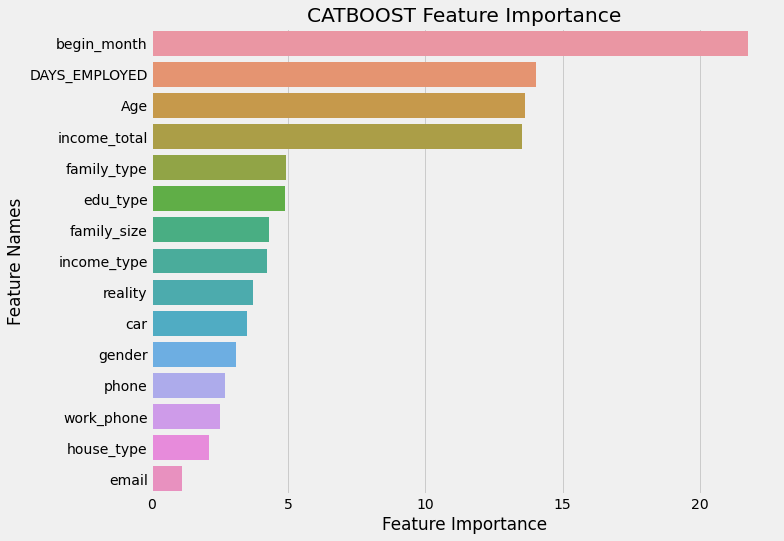

In [34]:
plot_feature_importance(cat.get_feature_importance(), x_traind1.columns, 'CATBOOST')

### 2) NA

In [24]:
train_n = train.copy()

In [25]:
#NA Imputation
train_n = train_n.fillna({'occyp_type':'NA'})

In [26]:
#gender, car, reality는 binary(object)

train_n['gender'] = train_n['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
train_n['car'] = train_n['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
train_n['reality'] = train_n['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

In [27]:
#음수값을 양수값으로 
train_n['DAYS_BIRTH'] = train_n['DAYS_BIRTH'].apply(lambda x: -x)
train_n['DAYS_EMPLOYED'] = train_n['DAYS_EMPLOYED'].apply(lambda x: -x)
train_n['begin_month'] = train_n['begin_month'].apply(lambda x: -x)

In [28]:
#DAYS_BIRTH로 나이 변수 만들어주기
train_n['Age'] = abs(train_n['DAYS_BIRTH'])/360
train_n = train_n.astype({'Age': 'int'})
train_n = train_n.drop('DAYS_BIRTH', axis=1)

In [29]:
train_n['income_type'] = enc.fit_transform(train_n['income_type'])
train_n['edu_type'] = enc.fit_transform(train_n['edu_type'])
train_n['family_type'] = enc.fit_transform(train_n['family_type'])
train_n['house_type'] = enc.fit_transform(train_n['house_type'])
train_n['occyp_type'] = enc.fit_transform(train_n['occyp_type'])

In [30]:
train_n = train_n.drop(['child_num'], axis=1)

In [31]:
#정규화 해보자
import numpy as np

reg = ['income_total', 'DAYS_EMPLOYED', 'family_size']
for i in reg :
    train_n[i] = (train_n[i] - min(train_n[i])) / (max(train_n[i]) - min(train_n[i]))

In [32]:
train_n = train_n.drop(['FLAG_MOBIL'], axis=1)

- training

In [33]:
x_trainn1 = train_n.drop('credit', axis=1)
y_trainn1 = train_n['credit']

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_trainn1, y_trainn1):
    folds.append((train_idx, valid_idx))

In [36]:
random.seed(42)
cat_models={}
outcomes=[]
for fold in range(5):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_trainn1.iloc[train_idx], x_trainn1.iloc[valid_idx], y_trainn1[train_idx], y_trainn1[valid_idx]
    cat = CatBoostClassifier()
    cat.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], use_best_model=True, 
            early_stopping_rounds=50,
           verbose=100) 
    cat_models[fold]=cat
    
    prediction = cat.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
Learning rate set to 0.114773
0:	learn: 1.0353246	test: 1.0353246	test1: 1.0351450	best: 1.0351450 (0)	total: 9.38ms	remaining: 9.37s
100:	learn: 0.7655220	test: 0.7655220	test1: 0.7882321	best: 0.7882321 (100)	total: 2.44s	remaining: 21.8s
200:	learn: 0.7286854	test: 0.7286854	test1: 0.7733763	best: 0.7733763 (200)	total: 5.35s	remaining: 21.3s
300:	learn: 0.6991501	test: 0.6991501	test1: 0.7645783	best: 0.7645783 (300)	total: 8.16s	remaining: 19s
400:	learn: 0.6730352	test: 0.6730352	test1: 0.7574005	best: 0.7574005 (400)	total: 10.8s	remaining: 16.1s
500:	learn: 0.6504945	test: 0.6504945	test1: 0.7518798	best: 0.7518798 (500)	total: 13.7s	remaining: 13.7s
600:	learn: 0.6306640	test: 0.6306640	test1: 0.7483448	best: 0.7483448 (600)	total: 16s	remaining: 10.6s
700:	learn: 0.6127724	test: 0.6127724	test1: 0.7455018	best: 0.7455018 (700)	total: 18.8s	remaining: 8.03s
800:	learn: 0.5960613	test: 0.5960613	t

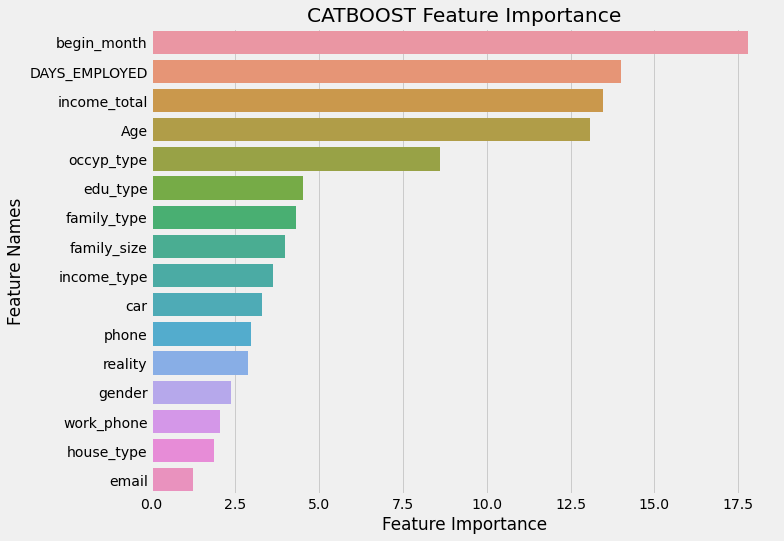

In [37]:
plot_feature_importance(cat.get_feature_importance(), x_trainn1.columns, 'CATBOOST')

## Model 비교 (LightGBM, XGBoost, Catboost)

- NA imputation 한 데이터로 진행
- LightGBM: 0.7587
- XGBoost: 0.7512
- Catboost: 0.7476

- 최종적으로 Catboost 모델 선택, 진행

### 1) LightGBM

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_trainn1, y_trainn1):
    folds.append((train_idx, valid_idx))

In [43]:
random.seed(42)
lgbm_models={}
outcomes=[]
for fold in range(5):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_trainn1.iloc[train_idx], x_trainn1.iloc[valid_idx], y_trainn1[train_idx], y_trainn1[valid_idx]
    lgbm = LGBMClassifier()
    lgbm.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric="logloss", 
            early_stopping_rounds=50,
           verbose=100) 
    lgbm_models[fold]=lgbm
    
    prediction = lgbm.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.65334	valid_1's multi_logloss: 0.750497
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.65334	valid_1's multi_logloss: 0.750497


====================================2============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.652201	valid_1's multi_logloss: 0.765922
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.652201	valid_1's multi_logloss: 0.765922


====================================3============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.655451	valid_1's multi_logloss: 0.761509
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.655451	valid_1's

### 2) XGBoost

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_trainn1, y_trainn1):
    folds.append((train_idx, valid_idx))

In [46]:
random.seed(42)
xgb_models={}
outcomes=[]
for fold in range(5):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_trainn1.iloc[train_idx], x_trainn1.iloc[valid_idx], y_trainn1[train_idx], y_trainn1[valid_idx]
    xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')
    xgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=50,
           verbose=100) 
    xgb_models[fold]=xgb
    
    prediction = xgb.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
[0]	validation_0-mlogloss:0.97449	validation_1-mlogloss:0.97717
[99]	validation_0-mlogloss:0.56476	validation_1-mlogloss:0.74326


====================================2============================================
[0]	validation_0-mlogloss:0.97357	validation_1-mlogloss:0.97906
[99]	validation_0-mlogloss:0.55787	validation_1-mlogloss:0.76102


====================================3============================================
[0]	validation_0-mlogloss:0.97459	validation_1-mlogloss:0.97831
[99]	validation_0-mlogloss:0.56025	validation_1-mlogloss:0.75409


====================================4============================================
[0]	validation_0-mlogloss:0.97391	validation_1-mlogloss:0.97816
[99]	validation_0-mlogloss:0.56064	validation_1-mlogloss:0.75325


====================================5============================================
[0]	validation_0-mlogloss:0.97457	validation_1-mlogloss:0.97728
[9

# 최종 모델링

- 15-fold로 진행

## FE

In [35]:
#NA Imputation
train = train.fillna({'occyp_type':'NA'})

### numerical

In [36]:
# 음수 -> 양수 변환
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: -x)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: -x)
train['begin_month'] = train['begin_month'].apply(lambda x: -x)

In [37]:
# DAYS_EMPLOYED < 0  -> 0으로 변환, year_employed 생성
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: x if x >=0 else 0)
train['year_employed'] = train['DAYS_EMPLOYED'] / 365
train['year_employed'] = train['year_employed'].astype('int')
#train = train.drop('DAYS_EMPLOYED', axis=1)

In [38]:
# DAYS_BIRTH -> Age
train['Age'] = train['DAYS_BIRTH'] / 365
train['Age'] = train['Age'].astype('int')
#train = train.drop('DAYS_BIRTH', axis=1)

In [39]:
# child_num 제거
train = train.drop('child_num', axis=1)
#train = train.drop('family_size', axis=1)

In [40]:
# family_size 이상치 제거
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

#child_num 이상치 제거
#train = train[(train['child_num'] <= 5)]
#train = train.reset_index(drop=True)

In [41]:
# start_work 추가
train['start_work'] = train['Age'] - train['year_employed']

In [42]:
train = train.astype({'begin_month':'int', 'family_size':'int', 'income_total':'int'})
#train = train.astype({'begin_month':'int', 'child_num':'int'})

In [43]:
# 소득/나이 비율, 소득/ 일한 기간 비율

train['income_age'] = train['income_total'] / train['Age']
train['income_employed'] = train['income_total'] / (train['year_employed'] + 1)

In [44]:
# 소득/ 가족 수 비율
train['income_family'] = train['income_total'] / train['family_size']

### binary

In [45]:
train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

### Categorical

In [19]:
#라벨인코딩
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

train['income_type'] = enc.fit_transform(train['income_type'])
train['edu_type'] = enc.fit_transform(train['edu_type'])
train['family_type'] = enc.fit_transform(train['family_type'])
train['house_type'] = enc.fit_transform(train['house_type'])
train['occyp_type'] = enc.fit_transform(train['occyp_type'])

### id 생성 (categorical 전처리)

In [20]:
#train['privat_id'] = train['email'] + train['house_type'] + train['work_phone'] + train['gender'] + train['reality'] + train['car'] + train['phone'] + train['income_type'] + train['edu_type'] + train['occyp_type'] + train['Age'] + train['year_employed']+ train['family_type']
#train['privat_id2'] = train['email'] + train['house_type'] + train['work_phone'] + train['gender'] + train['reality'] + train['car'] + train['phone'] + train['income_type'] + train['edu_type'] + train['occyp_type'] + train['Age'] + train['family_type'] + train['begin_month']

train['privat_id'] = train['gender'] + train['Age'] + train['income_total'] + train['income_type'] + train['occyp_type']
train['card_id'] = train['gender'] + train['Age'] + train['begin_month'] + train['income_total'] + train['income_type'] + \
                   train['occyp_type']

#train['card_id'] = train['gender'] + train['Age'] + train['income_total'] + train['income_type'] + train['occyp_type'] + train['begin_month']
#train['property_id'] = train['house_type'] + train['reality'] + train['car'] + train['income_total'] + train['gender']

#train['privat_id'] = train['gender'].astype('str') + train['Age'].astype('str') + train['income_total'].astype('str') + train['occyp_type'].astype('str')
#train['card_id'] = train['gender'].astype('str') + train['Age'].astype('str') + train['begin_month'].astype('str') + train['income_total'].astype('str') + train['income_type'].astype('str') + train['occyp_type'].astype('str')

# email, phone, work_phone 합치기
train['e_p'] = train['email'] + train['work_phone'] + train['phone']


#train['privat_id'] = \
#train['gender'] + train['Age'] + train['income_total'] + train['income_type'] + train['occyp_type'] + \
#train['family_size'] + train['car'] + train['gender'] + train['reality'] + train['income_type'] + \
#train['family_type'] + train['house_type']

#train['card_id'] = \
#train['gender'] + train['Age'] + train['income_total'] + train['income_type'] + train['occyp_type'] + \
#train['family_size'] + train['car'] + train['gender'] + train['reality'] + train['income_type'] + \
#train['family_type'] + train['house_type'] + train['begin_month']

### id 생성 (categorical 전처리 x)

In [46]:
train['privat_id'] = train['gender'].astype('str') + train['Age'].astype('str') + train['income_total'].astype('str') + \
                    train['occyp_type'].astype('str')
train['card_id'] = train['gender'].astype('str') + train['Age'].astype('str') + train['begin_month'].astype('str') + \
                   train['income_total'].astype('str') + train['income_type'].astype('str') + train['occyp_type'].astype('str')

In [47]:
train['e_p'] = train['email'] + train['work_phone'] + train['phone']

### Scaling

- minmax 보다 standard scaling이 좋은 결과

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [23]:
sca = StandardScaler()

In [48]:
train['income_total'] = sca.fit_transform(train[['income_total']])
train['year_employed'] = sca.fit_transform(train[['year_employed']])
#train['Age'] = sca.fit_transform(train[['Age']])
train['begin_month'] = sca.fit_transform(train[['begin_month']])
#train['start_work'] = sca.fit_transform(train[['start_work']])
train['income_age'] = sca.fit_transform(train[['income_age']])
train['income_employed'] = sca.fit_transform(train[['income_employed']])
train['income_family'] = sca.fit_transform(train[['income_family']])

### 제거 변수

- 상관관계 고려

In [49]:
#train = train.drop('family_size', axis=1)
train = train.drop('year_employed', axis=1)
#train = train.drop('DAYS_EMPLOYED', axis=1)
train = train.drop('DAYS_BIRTH', axis=1)

In [50]:
train = train.drop('FLAG_MOBIL', axis=1)

In [27]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,Age,start_work,income_age,income_employed,income_family,privat_id,card_id,e_p
0,0,0,0,0.149115,0,1,1,2,4709,0,0,0,12,2,-1.215242,1.0,38,26,0.219075,-0.710383,0.002062,202550,202556,0
1,0,0,1,0.590785,0,4,0,1,1540,0,0,1,8,3,-1.275633,1.0,31,27,1.134798,-0.242290,-0.254157,247539,247544,1
2,1,1,1,2.578304,4,1,1,1,4434,0,1,0,10,2,-0.248981,2.0,52,40,1.365883,-0.447678,1.693108,450067,450089,1
3,0,0,1,0.149115,0,4,1,1,2092,0,1,0,15,2,0.656889,0.0,41,36,0.084584,-0.459619,0.002062,202556,202593,1
4,0,1,1,-0.292556,2,1,1,1,2105,0,0,0,10,2,-0.007416,2.0,41,36,-0.293981,-0.563109,-0.305401,157553,157579,0


# Modeling 1) categorical feature 전처리

- loss: 0.7305

In [29]:
x_train1 = train.drop('credit', axis=1)
y_train1 = train['credit']

In [30]:
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_train1, y_train1):
    folds.append((train_idx, valid_idx))

In [31]:
random.seed(42)
cat_models={}
outcomes=[]
for fold in range(15):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_train1.iloc[train_idx], x_train1.iloc[valid_idx], y_train1[train_idx], y_train1[valid_idx]
    cat = CatBoostClassifier()
    cat.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], use_best_model=True, 
            early_stopping_rounds=50,
           verbose=100) 
    cat_models[fold]=cat
    
    prediction = cat.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
Learning rate set to 0.115127
0:	learn: 1.0342935	test: 1.0342935	test1: 1.0330168	best: 1.0330168 (0)	total: 166ms	remaining: 2m 46s
100:	learn: 0.7612110	test: 0.7612110	test1: 0.7774570	best: 0.7773944 (99)	total: 1.28s	remaining: 11.4s
200:	learn: 0.7235565	test: 0.7235565	test1: 0.7578793	best: 0.7578793 (200)	total: 2.34s	remaining: 9.32s
300:	learn: 0.6931386	test: 0.6931386	test1: 0.7434079	best: 0.7434079 (300)	total: 3.45s	remaining: 8.01s
400:	learn: 0.6682931	test: 0.6682931	test1: 0.7323249	best: 0.7323249 (400)	total: 4.53s	remaining: 6.76s
500:	learn: 0.6468531	test: 0.6468531	test1: 0.7243193	best: 0.7243193 (500)	total: 5.64s	remaining: 5.62s
600:	learn: 0.6269782	test: 0.6269782	test1: 0.7168709	best: 0.7168709 (600)	total: 6.71s	remaining: 4.46s
700:	learn: 0.6090913	test: 0.6090913	test1: 0.7124231	best: 0.7123662 (699)	total: 7.79s	remaining: 3.32s
800:	learn: 0.5935661	test: 0.593566

100:	learn: 0.7646848	test: 0.7646848	test1: 0.7805317	best: 0.7805317 (100)	total: 1.5s	remaining: 13.3s
200:	learn: 0.7249847	test: 0.7249847	test1: 0.7641093	best: 0.7641093 (200)	total: 2.94s	remaining: 11.7s
300:	learn: 0.6948757	test: 0.6948757	test1: 0.7527011	best: 0.7527011 (300)	total: 4.33s	remaining: 10.1s
400:	learn: 0.6684528	test: 0.6684528	test1: 0.7443132	best: 0.7443132 (400)	total: 5.73s	remaining: 8.57s
500:	learn: 0.6459785	test: 0.6459785	test1: 0.7377886	best: 0.7377886 (500)	total: 7.2s	remaining: 7.17s
600:	learn: 0.6269280	test: 0.6269280	test1: 0.7338807	best: 0.7338807 (600)	total: 8.59s	remaining: 5.7s
700:	learn: 0.6091615	test: 0.6091615	test1: 0.7311645	best: 0.7311106 (699)	total: 10s	remaining: 4.28s
800:	learn: 0.5923329	test: 0.5923329	test1: 0.7283791	best: 0.7283747 (798)	total: 11.4s	remaining: 2.84s
900:	learn: 0.5770849	test: 0.5770849	test1: 0.7265057	best: 0.7263971 (898)	total: 12.9s	remaining: 1.42s
999:	learn: 0.5633631	test: 0.5633631	test

100:	learn: 0.7640563	test: 0.7640563	test1: 0.7903521	best: 0.7903521 (100)	total: 1.43s	remaining: 12.7s
200:	learn: 0.7250922	test: 0.7250922	test1: 0.7742360	best: 0.7742360 (200)	total: 2.76s	remaining: 11s
300:	learn: 0.6928476	test: 0.6928476	test1: 0.7601267	best: 0.7601267 (300)	total: 4.04s	remaining: 9.38s
400:	learn: 0.6666693	test: 0.6666693	test1: 0.7543122	best: 0.7543122 (400)	total: 5.37s	remaining: 8.02s
500:	learn: 0.6448300	test: 0.6448300	test1: 0.7485759	best: 0.7485093 (498)	total: 6.65s	remaining: 6.63s
600:	learn: 0.6257707	test: 0.6257707	test1: 0.7440471	best: 0.7439069 (593)	total: 7.98s	remaining: 5.29s
700:	learn: 0.6074275	test: 0.6074275	test1: 0.7388270	best: 0.7388270 (700)	total: 9.29s	remaining: 3.96s
800:	learn: 0.5904912	test: 0.5904912	test1: 0.7358139	best: 0.7354644 (785)	total: 10.6s	remaining: 2.64s
900:	learn: 0.5749539	test: 0.5749539	test1: 0.7333275	best: 0.7333275 (900)	total: 12s	remaining: 1.31s
999:	learn: 0.5605801	test: 0.5605801	tes

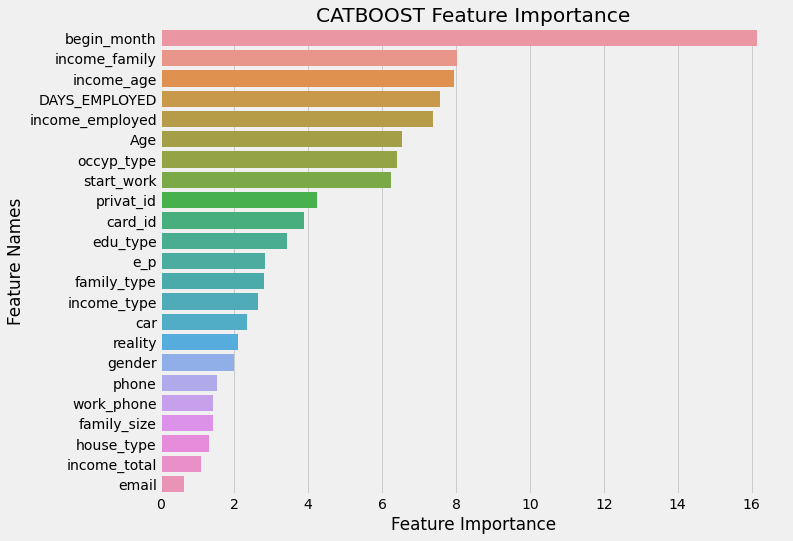

In [32]:
plot_feature_importance(cat.get_feature_importance(), x_train1.columns, 'CATBOOST')

# Modeling 2) categorical feature 전처리 x

- loss: 0.6844

In [51]:
x_train2 = train.drop('credit', axis=1)
y_train2 = train['credit']

In [52]:
x_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           26451 non-null  int64  
 1   car              26451 non-null  int64  
 2   reality          26451 non-null  int64  
 3   income_total     26451 non-null  float64
 4   income_type      26451 non-null  object 
 5   edu_type         26451 non-null  object 
 6   family_type      26451 non-null  object 
 7   house_type       26451 non-null  object 
 8   DAYS_EMPLOYED    26451 non-null  int64  
 9   work_phone       26451 non-null  int64  
 10  phone            26451 non-null  int64  
 11  email            26451 non-null  int64  
 12  occyp_type       26451 non-null  object 
 13  family_size      26451 non-null  int32  
 14  begin_month      26451 non-null  float64
 15  Age              26451 non-null  int32  
 16  start_work       26451 non-null  int32  
 17  income_age  

- categorical 변수

In [53]:
cat_features = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'privat_id', 'card_id']

In [54]:
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(x_train2, y_train2):
    folds.append((train_idx, valid_idx))

In [55]:
random.seed(42)
cat_models={}
outcomes=[]
for fold in range(15):
    
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = x_train2.iloc[train_idx], x_train2.iloc[valid_idx], y_train2[train_idx], y_train2[valid_idx]
    cat = CatBoostClassifier()
    cat.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], use_best_model=True, 
            early_stopping_rounds=50, cat_features = cat_features,
           verbose=100) 
    cat_models[fold]=cat
    
    prediction = cat.predict_proba(X_valid)
    logloss = log_loss(to_categorical(y_valid), prediction)
    outcomes.append(logloss)
    print(f'================================================================================\n\n')
    
mean_outcome = np.mean(outcomes)
print("mean:{}".format(mean_outcome))

====================================1============================================
Learning rate set to 0.115127
0:	learn: 1.0347903	test: 1.0347827	test1: 1.0334631	best: 1.0334631 (0)	total: 74.3ms	remaining: 1m 14s
100:	learn: 0.7209686	test: 0.5070745	test1: 0.6670750	best: 0.6670750 (100)	total: 11s	remaining: 1m 37s
200:	learn: 0.6999318	test: 0.4907987	test1: 0.6617527	best: 0.6617063 (186)	total: 24.4s	remaining: 1m 36s
300:	learn: 0.6838107	test: 0.4815542	test1: 0.6586789	best: 0.6586789 (300)	total: 37.7s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6583820683
bestIteration = 308

Shrink model to first 309 iterations.


====================================2============================================
Learning rate set to 0.115127
0:	learn: 1.0346784	test: 1.0346344	test1: 1.0340080	best: 1.0340080 (0)	total: 67.6ms	remaining: 1m 7s
100:	learn: 0.7205299	test: 0.5027774	test1: 0.6922540	best: 0.6918430 (94)	total: 10.4s	remaining: 1m 32

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6805115307
bestIteration = 302

Shrink model to first 303 iterations.


====================================12============================================
Learning rate set to 0.115127
0:	learn: 1.0345655	test: 1.0344962	test1: 1.0350228	best: 1.0350228 (0)	total: 105ms	remaining: 1m 44s
100:	learn: 0.7176024	test: 0.5025658	test1: 0.7086076	best: 0.7086076 (100)	total: 10.9s	remaining: 1m 37s
200:	learn: 0.6972867	test: 0.4841758	test1: 0.7067501	best: 0.7064650 (181)	total: 22.9s	remaining: 1m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7064650411
bestIteration = 181

Shrink model to first 182 iterations.


====================================13============================================
Learning rate set to 0.115127
0:	learn: 1.0356012	test: 1.0354124	test1: 1.0356089	best: 1.0356089 (0)	total: 85.3ms	remaining: 1m 25s
100:	learn: 0.7202948	test: 0.4999251	test1: 0.6928662	best: 0.692866

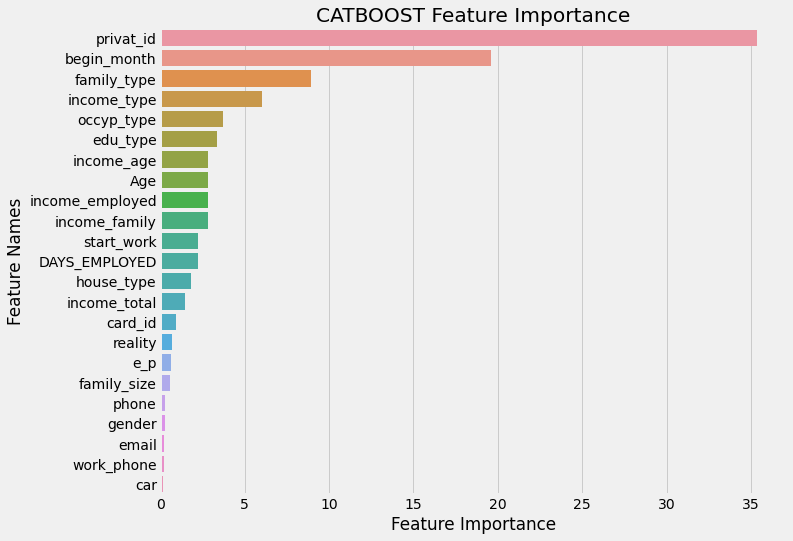

In [56]:
plot_feature_importance(cat.get_feature_importance(), x_train2.columns, 'CATBOOST')